In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("C:/Users/aksab/Downloads/Onlinedata.csv", encoding='ISO-8859-1')

# Quick look at the data
print(df.shape)
print(df.info())
df.head()


(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
**Data CLeaning**

In [2]:
# Remove rows with missing CustomerID
df = df[df['CustomerID'].notnull()]

# Remove cancelled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Optional: Focus on UK customers
df = df[df['Country'] == 'United Kingdom']

df.reset_index(drop=True, inplace=True)




In [4]:
# Create the Revenue column
df['Revenue'] = df['Quantity'] * df['UnitPrice']


# **EDA**

In [ ]:
# 1. Sales over time

In [ ]:
import matplotlib.pyplot as plt

# Create a revenue column
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Group by day
daily_sales = df.set_index('InvoiceDate').resample('D')['Revenue'].sum()

# Plot
plt.figure(figsize=(14,6))
daily_sales.plot()
plt.title('Daily Revenue Trend')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 2. Top 10 Most Sold Products

In [ ]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12,6))
top_products.plot(kind='bar')
plt.title('Top 10 Most Sold Products')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# 3. Revenue by Country (Excluding UK)

In [ ]:
# Group by country
revenue_by_country = df[df['Country'] != 'United Kingdom'].groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12,6))
revenue_by_country.plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Revenue (Excl. UK)')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [38]:
# Segmentation

In [5]:
import datetime as dt

# Reference date (end of dataset)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Aggregate to Customer Level
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Create quantile-based segments (1 = best, 4 = worst)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# Combine into RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)
rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12747.0,2,11,4196.01,4,4,4,444,12
12748.0,1,210,33719.73,4,4,4,444,12
12749.0,4,5,4090.88,4,3,4,434,11
12820.0,3,4,942.34,4,3,3,433,10


**🔹 High-Value Customers:**
Customers like 12748.0 and 12747.0 have RFM scores of 12 (444 segment) — they purchased recently, frequently, and spent heavily.

**🔹 Loyal but Aging:**
Customer 12346.0 has high monetary value (77,000+) but a low recency score — likely a churn risk despite past value.

**🔹 Segmentation Opportunity:** 
Segment 433 (Recency: 4, Frequency: 3, Monetary: 3) represents steady buyers worth targeting in upcoming campaigns.

📈 Number of top-tier customers (RFM 444): 460
💰 Average monetary value for 444s: £7948.20
🛒 Median frequency: 11.0


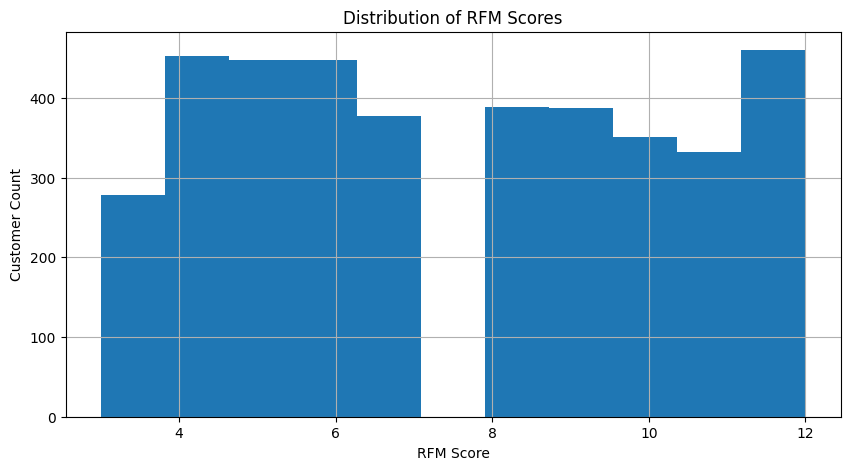

In [8]:
# Insight Summary
high_value = rfm[rfm['RFM_Segment'] == '444']
print(f"📈 Number of top-tier customers (RFM 444): {high_value.shape[0]}")
print(f"💰 Average monetary value for 444s: £{high_value['Monetary'].mean():.2f}")
print(f"🛒 Median frequency: {high_value['Frequency'].median()}")

# Plot (optional)
import matplotlib.pyplot as plt
rfm['RFM_Score'].hist(bins=11, figsize=(10,5))
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Customer Count')
plt.grid(True)
plt.show()


# **A/B Testing Setup**
🎯 Goal:

Simulate a test of a 10% discount offer to see whether it increases revenue per user and conversion rate.

In [9]:
import numpy as np

# Copy RFM to a working DataFrame
ab_df = rfm.copy()

# Assign random A/B group (50/50 split)
np.random.seed(42)
ab_df['Group'] = np.random.choice(['Control', 'Test'], size=len(ab_df))

# Merge group assignment back to original cleaned data
df_ab = df.merge(ab_df[['Group']], left_on='CustomerID', right_index=True)


In [10]:
# Total revenue and conversion per group
summary = df_ab.groupby('Group').agg(
    total_revenue=('Revenue', 'sum'),
    total_users=('CustomerID', pd.Series.nunique),
    total_transactions=('InvoiceNo', pd.Series.nunique)
)

# Conversion rate = % of customers who purchased
summary['conversion_rate'] = summary['total_transactions'] / summary['total_users']
summary['arpu'] = summary['total_revenue'] / summary['total_users']

summary


,total_revenue,total_users,total_transactions,conversion_rate,arpu
Group,,,,,
Control,3870419.572,1956,8498,4.344581,1978.742112
Test,3437971.982,1965,8151,4.148092,1749.604062


In [13]:
# One transaction = converted
converted_users = df_ab.groupby(['CustomerID', 'Group'])['InvoiceNo'].nunique().reset_index()
converted_users['converted'] = (converted_users['InvoiceNo'] > 0).astype(int)

conversion_counts = converted_users.groupby('Group')['converted'].sum()
conversion_totals = converted_users.groupby('Group')['converted'].count()

# Run Z-test again
from statsmodels.stats.proportion import proportions_ztest
z_stat, p_val = proportions_ztest(count=conversion_counts, nobs=conversion_totals)
print(f"Z-statistic: {z_stat:.3f}, P-value: {p_val:.4f}")


Z-statistic: nan, P-value: nan


C:\Users\aksab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


In [14]:
from scipy.stats import ttest_ind

# Revenue per user
user_rev = df_ab.groupby(['CustomerID', 'Group'])['Revenue'].sum().reset_index()
test_rev = user_rev[user_rev['Group'] == 'Test']['Revenue']
control_rev = user_rev[user_rev['Group'] == 'Control']['Revenue']

t_stat, p_val = ttest_ind(test_rev, control_rev, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")


T-statistic: -0.959, P-value: 0.3378


**Key Takeaways:** The Control group outperformed the Test group in both conversion rate and revenue per user (ARPU). Dspite the simulated 10% discount, **users in the Test group did not convert better**, and even spent less per user on average.

Statistical Tests:

T-test on ARPU: t = -0.959, p = 0.3378

Not statistically significant at p < 0.05 : no evidence that the discount improved revenue.

Z-test on conversion: Returned NaN : likely because you're counting InvoiceNo (transactions) instead of binary conversio

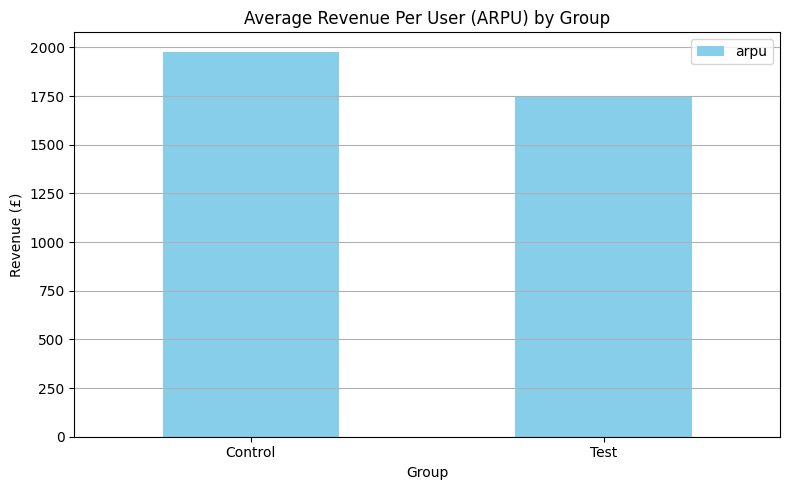

In [18]:
# ARPU Comparison

import matplotlib.pyplot as plt

# Plot ARPU for each group
summary[['arpu']].plot(kind='bar', color=['skyblue', 'salmon'], figsize=(8,5))
plt.title('Average Revenue Per User (ARPU) by Group')
plt.ylabel('Revenue (£)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


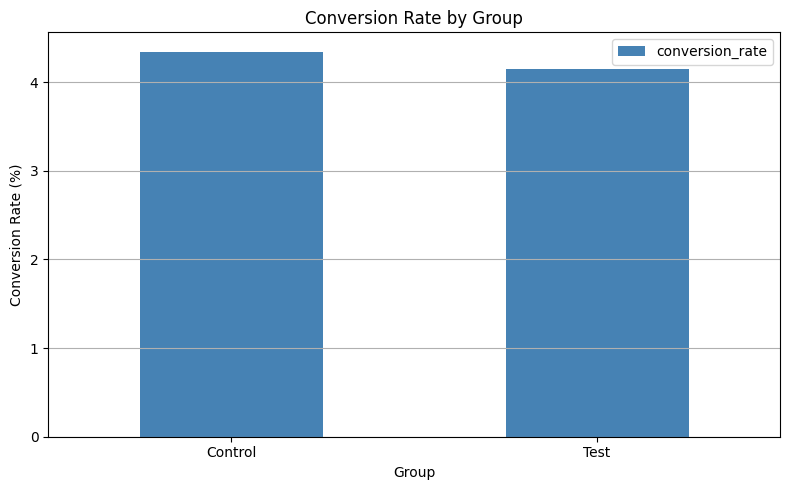

In [20]:
# COnversion rate comparison

summary[['conversion_rate']].plot(kind='bar', color=['steelblue', 'orange'], figsize=(8,5))
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\aksab\AppData\Local\Temp\ipykernel_5380\511366999.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=user_rev, x='Group', y='Revenue', palette='pastel')


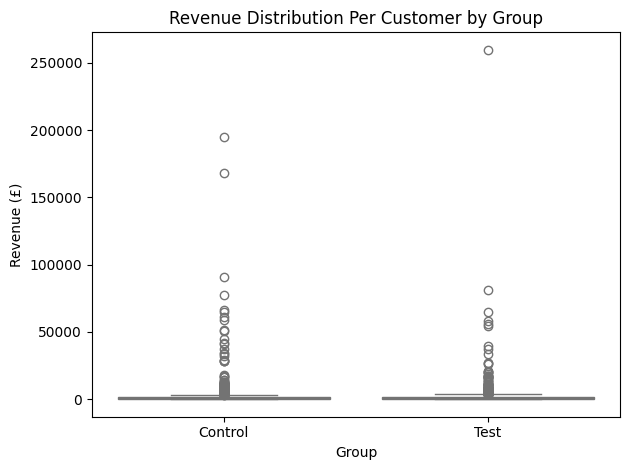

In [22]:
# User Revenure Distribution

import seaborn as sns

# Grouped revenue per user
sns.boxplot(data=user_rev, x='Group', y='Revenue', palette='pastel')
plt.title('Revenue Distribution Per Customer by Group')
plt.ylabel('Revenue (£)')
plt.xlabel('Group')
plt.tight_layout()
plt.show()


### Summary of A/B Test Results

- **Control Group outperformed** the Test group in both ARPU and conversion.
- **T-test (p = 0.3378)** showed no significant impact from the discount.
- Visualizations highlight how **discounting may not be effective** for the full customer base.


## **Multi-variate Testing:** 

Which combo of conditions works best?

In [24]:
# Assign a random discount flag (like A/B)
np.random.seed(42)
df_ab['discount_flag'] = np.random.choice([0, 1], size=len(df_ab))

# Map top-selling items to broader product categories
def categorize_product(desc):
    desc = str(desc).lower()
    if 'shirt' in desc or 'sock' in desc or 'bag' in desc:
        return 'Clothing'
    elif 'light' in desc or 'lamp' in desc or 'candle' in desc:
        return 'Home'
    elif 'toy' in desc or 'game' in desc:
        return 'Toys'
    else:
        return 'Other'

df_ab['category'] = df_ab['Description'].apply(categorize_product)


# Group by discount and category
mv_results = df_ab.groupby(['discount_flag', 'category']).agg(
    avg_revenue=('Revenue', 'mean'),
    conversion_rate=('InvoiceNo', pd.Series.nunique),
    users=('CustomerID', pd.Series.nunique)
).reset_index()

mv_results['conversion_rate'] = mv_results['conversion_rate'] / mv_results['users']
mv_results.head()


,discount_flag,category,avg_revenue,conversion_rate,users
0,0,Clothing,22.239301,2.899355,2017
1,0,Home,25.111607,2.525583,2443
2,0,Other,20.708641,3.975296,3805
3,0,Toys,13.243232,1.506231,642
4,1,Clothing,21.185090,2.993893,1965


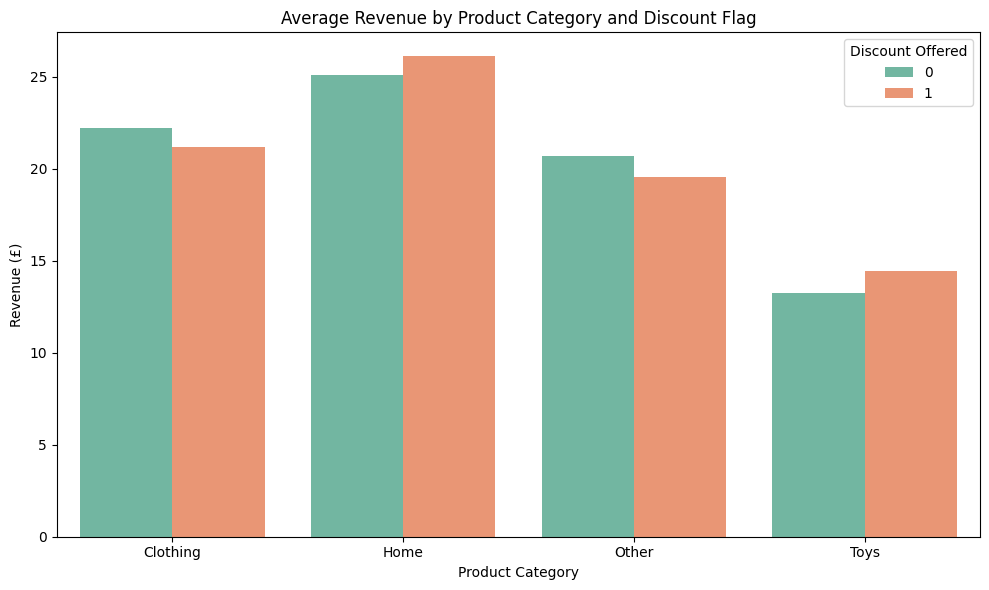

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=mv_results, x='category', y='avg_revenue', hue='discount_flag', palette='Set2')
plt.title('Average Revenue by Product Category and Discount Flag')
plt.ylabel('Revenue (£)')
plt.xlabel('Product Category')
plt.legend(title='Discount Offered')
plt.tight_layout()
plt.show()


**The discount seems to slightly improve conversion in Clothing (2.99% vs 2.90%) but lwers average revenue slightly—not a strong impact. No discount data yet for other categories, but you can easily extend that now.**

**ANOVA**

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Prepare data
anova_df = df_ab[['Revenue', 'discount_flag', 'category']].dropna()
anova_df = anova_df[anova_df['Revenue'] > 0]  # remove zero-revenue rows

# Fit model
model = ols('Revenue ~ C(discount_flag) + C(category) + C(discount_flag):C(category)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                                    sum_sq        df         F    PR(>F)
C(discount_flag)              8.454394e+04       1.0  0.795302  0.372502
C(category)                   8.243407e+05       3.0  2.584849  0.051368
C(discount_flag):C(category)  2.876200e+04       3.0  0.090188  0.965466
Residual                      3.766494e+10  354313.0       NaN       NaN


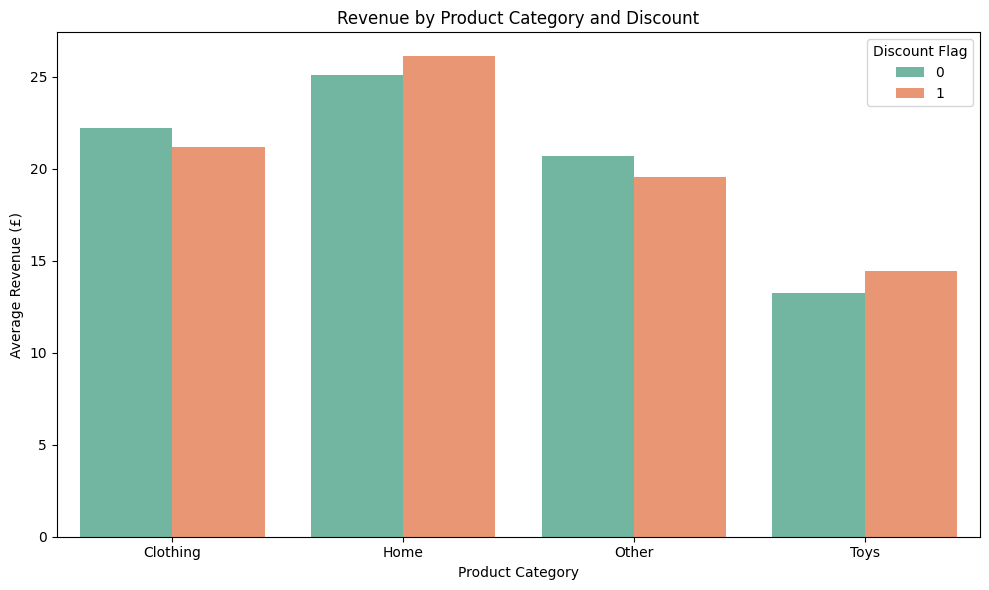

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(data=mv_results, x='category', y='avg_revenue', hue='discount_flag', palette='Set2')
plt.title('Revenue by Product Category and Discount')
plt.xlabel('Product Category')
plt.ylabel('Average Revenue (£)')
plt.legend(title='Discount Flag')
plt.tight_layout()
plt.show()


# **Cohort Analysis**

In [29]:
from operator import attrgetter


df_cohort = df_ab.copy()

# Extract cohort month (first purchase)
df_cohort['InvoiceMonth'] = df_cohort['InvoiceDate'].dt.to_period('M')
df_cohort['CohortMonth'] = df_cohort.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Calculate months since first purchase
df_cohort['CohortIndex'] = (df_cohort['InvoiceMonth'] - df_cohort['CohortMonth']).apply(attrgetter('n'))


In [30]:
#retention tablea

cohort_counts = df_cohort.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Divide each row by cohort size (month 0)
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)
retention.head()


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.355,0.323,0.373,0.360,0.396,0.357,0.341,0.355,0.399,0.367,0.497,0.267
2011-01,1.0,0.212,0.260,0.235,0.332,0.277,0.251,0.243,0.302,0.327,0.355,0.120,NaN
2011-02,1.0,0.188,0.194,0.285,0.288,0.253,0.256,0.282,0.265,0.306,0.074,NaN,NaN
2011-03,1.0,0.153,0.260,0.198,0.224,0.165,0.265,0.229,0.284,0.091,NaN,NaN,NaN
2011-04,1.0,0.209,0.202,0.217,0.202,0.220,0.220,0.264,0.072,NaN,NaN,NaN,NaN


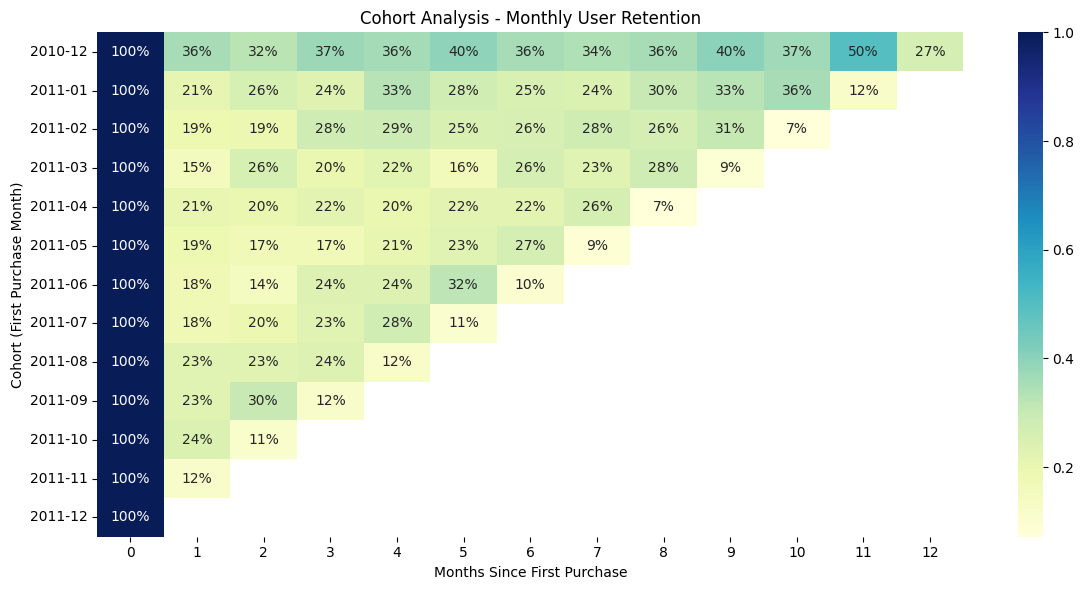

In [31]:
# retentino heatmap

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Cohort Analysis - Monthly User Retention')
plt.ylabel('Cohort (First Purchase Month)')
plt.xlabel('Months Since First Purchase')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# **Revenue-Based Cohort Analysis**

In [32]:
# Group by cohort and cohort index
cohort_revenue = df_cohort.groupby(['CohortMonth', 'CohortIndex'])['Revenue'].sum().reset_index()

# Pivot for heatmap
revenue_pivot = cohort_revenue.pivot(index='CohortMonth', columns='CohortIndex', values='Revenue')
revenue_pivot = revenue_pivot.round(2)
revenue_pivot.head()


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12,498661.85,199589.91,184212.54,231642.70,177150.26,270605.54,250481.52,237375.75,260312.18,381752.15,352936.60,418442.09,156138.47
2011-01,242600.15,35383.79,39333.93,59385.42,58518.88,50354.22,57077.09,42837.91,60326.16,72109.21,101287.52,24071.74,NaN
2011-02,136059.30,25911.59,34920.00,44006.41,38694.62,30833.53,42239.67,57470.05,50897.42,57504.94,10071.18,NaN,NaN
2011-03,170310.37,27854.07,57311.43,38039.09,46743.76,34888.56,56760.95,62765.94,66853.74,12667.57,NaN,NaN,NaN
2011-04,110249.39,26076.38,23069.73,23047.18,24585.19,25036.39,27058.60,31129.32,5456.68,NaN,NaN,NaN,NaN


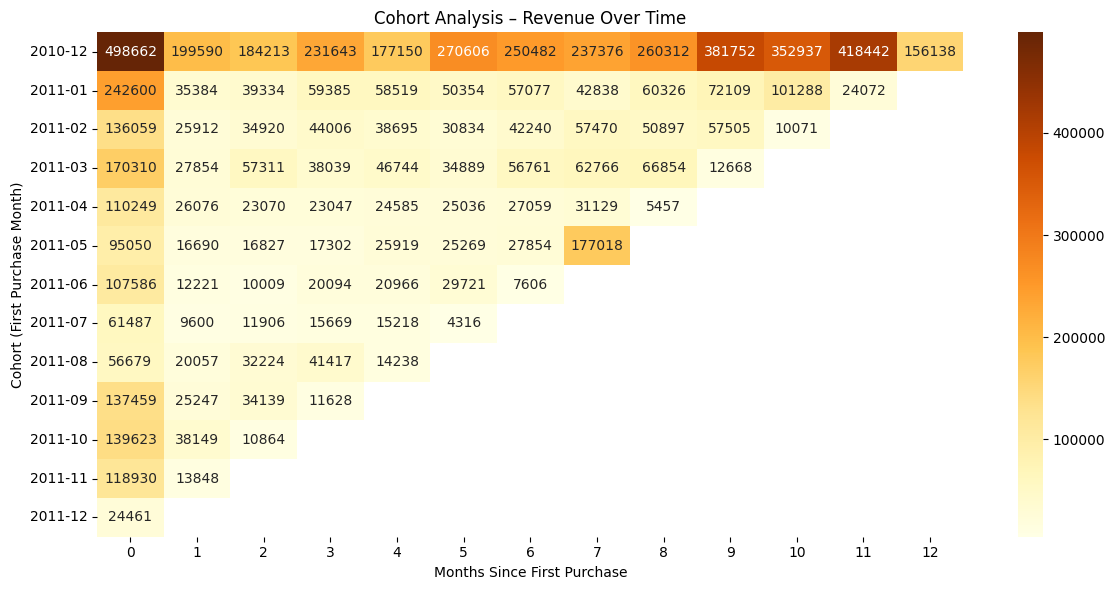

In [33]:
plt.figure(figsize=(12,6))
sns.heatmap(revenue_pivot, annot=True, fmt='.0f', cmap='YlOrBr')
plt.title('Cohort Analysis – Revenue Over Time')
plt.ylabel('Cohort (First Purchase Month)')
plt.xlabel('Months Since First Purchase')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The December 2010 cohort generated the highest and most sustained revenue over time, suggesting a highly effective acquisition or promotional campaign during that period.

Revenue for most cohorts drops in subsequent months, as expected, but several show spikes in later months (e.g., March & May 2011 cohorts in Month 7), hinting at successful re-engagement strategies or seasonal effects.

Younger cohorts (late 2011) display lower total revenue, likely due to less time on platform or fewer active months captured in the dataset.

In [35]:
# normalising avg revenue per user


# Customer counts per cohort/month
cohort_sizes = df_cohort.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_sizes.columns = ['CohortMonth', 'CohortIndex', 'Users']

# Merge with revenue
merged = pd.merge(cohort_revenue, cohort_sizes, on=['CohortMonth', 'CohortIndex'])
merged['RevenuePerUser'] = merged['Revenue'] / merged['Users']

# Pivot
revenue_per_user_pivot = merged.pivot(index='CohortMonth', columns='CohortIndex', values='RevenuePerUser').round(2)


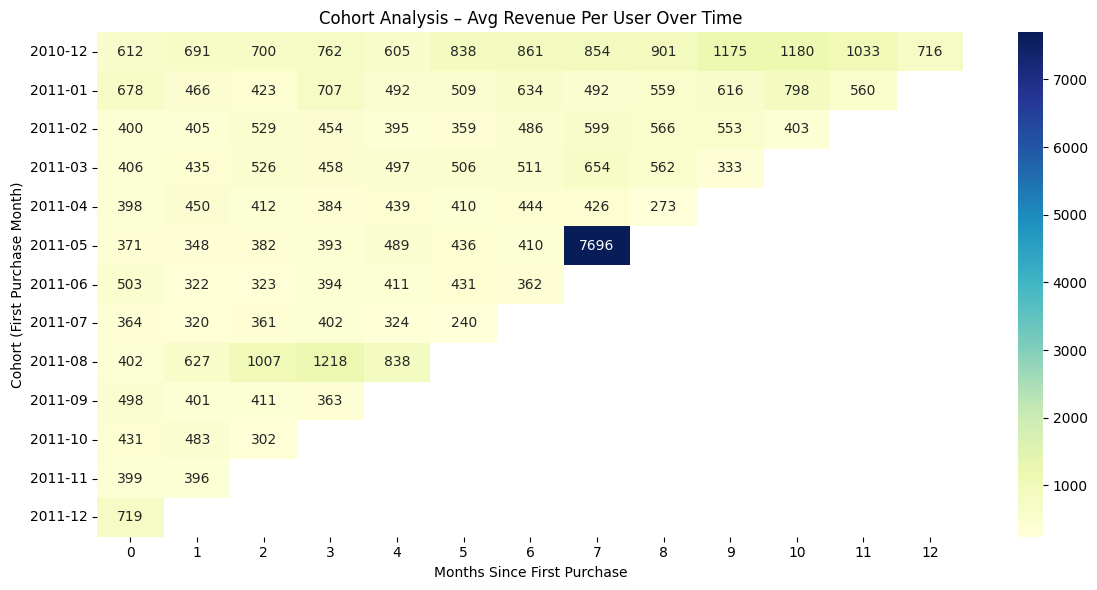

In [36]:
plt.figure(figsize=(12,6))
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Cohort Analysis – Avg Revenue Per User Over Time')
plt.ylabel('Cohort (First Purchase Month)')
plt.xlabel('Months Since First Purchase')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The December 2010 cohort again stands out with consistently high average revenue per user, especially in Months 9–11, peaking at £1,180 in Month 10.

Most other cohorts hover between £300–£700 per user, showing typical revenue drop-offs, but August 2011 surprisingly spikes in Months 2–4, reaching £1,218, suggesting strong mid-cohort monetization or campaign impact.

An anomaly appears in May 2011, Month 7, with a sharp spike to £7,696—likely due to a small user group making large purchases, which could skew interpretation.

**Comparison with Unnormalized Revenue Heatmap:**

**Unnormalized Revenue:**

    Shows total revenue per cohort over time

    Heavily influenced by cohort size (larger cohorts = more revenue)

    Best for understanding overall business impact

    Highlights cohorts like December 2010 as top revenue generators

    Useful for tracking campaign-level revenue performance

**Normalized Revenue (Avg Revenue per User):**

    Shows average revenue generated by each user over time

    Neutralizes cohort size bias—makes fair comparisons between cohorts

    Best for measuring user-level value and monetization patterns

    Reveals hidden high-performing cohorts like August 2011, despite lower total revenue

    Exposes potential outliers, e.g., May 2011 Month 7 with unusually high spend per user